### Required Packages

In [1001]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cyvcf2 import VCF
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# Submission Code 

## Extract and Format Variant Information

In [1002]:
vcf_file_path = "data/SNV.somatic.sweetelf.merged.clinical.ranked.vcf.gz"

In [615]:
def parse_csq(fields, csq_str):
    csq = []
    annotation_list = csq_str.split(",")
    for annotation in annotation_list:   
        csq.append(dict(zip(fields, annotation.split("|"))))
        return csq

def extract_csq_keys(parsed_csq, keys):
    annos = []
    values = []
    
    for anno in parsed_csq:
        for item in anno.items():
            if item[0] in keys:
                annos.append(item[0])
                values.append(item[1])
    return dict(zip(annos, values))    

def extract_info_keys(info_field, keys):
    annos = []
    values = []
    
    for key in keys:
        annos.append(key)
        values.append(info_field.get(key, ""))
        
    return dict(zip(annos, values))

def parse_vcf(path_to_vcf):
    vcf = VCF(path_to_vcf)
    csq_fields = vcf.get_header_type("CSQ")["Description"][51:-1].split("|")
    data = []
    for variant in vcf:
        chrom = variant.CHROM
        pos = variant.POS
        ref = variant.REF
        alt = variant.ALT[0] 
        filter_value = variant.FILTER
        
        info = variant.INFO
        #info_keys = ["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]
        # extract INFO-keys
        info_keys = extract_info_keys(info, keys=["CSQ", "RankResult", "RankScore", "CLNSIG", "AF", "DP", "GNOMAD_AF"]) 
        
        #csq_str = info.get("CSQ", "") 
        af, pp, con, vcqf, lin, clin = [float(x) for x in info_keys.get("RankResult", "0|0|0|0|0|0").split("|")]   
        rank_score = float(info_keys.get("RankScore")[2:])    
        clnsig = info_keys.get("CLNSIG", "") 
        vaf = info_keys.get("AF", "")
        coverage = info_keys.get("DP", "")

        # Parse CSQ 
        csq = parse_csq(csq_fields, info_keys.get("CSQ", ""))
        csq_keys = extract_csq_keys(csq, keys = ["Consequence", "SIFT", "PolyPhen", "gnomAD_AF", "COSMIC", "CLIN_SIG"])


        # Format strings for extracting controls
        chrom_pos = f"{chrom}_{pos}"
        ref_alt = f"{ref}_{alt}"
        
        data.append({
            "VARIANT": f"{chrom_pos}_{ref_alt}",
            "CHROM_POS": chrom_pos,
            "AF": af,
            "PP": pp,
            "CON": con,
            "VCQF": vcqf,
            "LIN": lin,
            "CLIN": clin,
            "CLNSIG": clnsig,
            "RANK_SCORE": rank_score,
            #"parsed_csq": csq,
            #"csq_key": csq_keys,
            #"Consequence": csq_keys.get("Consequence", ""), 
            #"SIFT": csq_keys.get("SIFT", ""), 
            #"PolyPhen": csq_keys.get("PolyPhen", ""), 
            #"gnomAD_AF": csq_keys.get("gnomAD_AF", ""), 
            #"COSMIC": csq_keys.get("COSMIC", ""), 
            #"CLIN_SIG": csq_keys.get("CLIN_SIG", ""),
            #"FILTER": filter_value,
            #"VAF(AF)": vaf,
            #"COVERAGE(DP)": coverage
        })
    return pd.DataFrame(data)

## Group Variants and Mark Controls

In [1006]:
GROUPS_WITH_LABELS = {
    "benign": ['Benign',
               'Likely_benign',
               'Benign/Likely_benign',
               'Benign|drug_response',
               'Likely_benign|other',
               'Likely_benign|drug_response|other'],
    "pathogenic": ['Pathogenic',
                   'Pathogenic/Likely_pathogenic',
                   'Pathogenic|other',
                   'Likely_pathogenic',
                   'Likely_pathogenic|association',
                   'Pathogenic/Likely_pathogenic|risk_factor'],
    "uncertain": ['Conflicting_classifications_of_pathogenicity',
                  'Conflicting_classifications_of_pathogenicity|drug_response|other',
                  'Conflicting_classifications_of_pathogenicity|association',
                  'Uncertain_significance'],
    "other": ['', 'not_provided', 'drug_response']
}

def group_variants(df, from_col="CLNSIG", groups=GROUPS_WITH_LABELS, to_col="GROUP", controls="data/controls_match.tsv"):
    """ 
    Groups variants by 'groups' based on information in 'from_col'.
    Adjusts RANK_SCORE by subtracting CLIN Score to mitigate bias.
    Args:
    df (pd.DataFrame): data with variants to group
    from_col (str): the column in df to use for grouping (required in df)
    to_col (str): the name of the new column that will contain variant group labels
    Returns:
    df (pd.DataFrame): the df extended with 'to_column' values and 'ADJUSTED_SCORE'. 
    """
    df[from_col] = df[from_col].str.strip()
    
    def classify(clnsig):
        for group, labels in groups.items():
            if clnsig in labels:
                return group
        print(f"Unmatched CLNSIG value: {clnsig}")  # Log unmatched values
        return "other"  # Return original label if no match is found

    # Apply the classification logic to the DataFrame
    df[to_col] = df[from_col].apply(classify)
    
    df["ADJUSTED_SCORE"] = df["RANK_SCORE"] - df["CLIN"]
    
    return mark_controls(df, controls)

def mark_controls(df, controls):
    c = pd.read_csv(controls, sep="\t")
    control_set = set(c["chrom_pos"])
    df["IS_CONTROL"] = df["CHROM_POS"].isin(control_set)
    return df

In [1007]:
# read VCF file into a pandas Dataframe 
df = parse_vcf(vcf_file_path)

In [1008]:
# Group variants and mark controls 
df = group_variants(df.copy())

In [1009]:
df.head(1)

,VARIANT,CHROM_POS,AF,PP,CON,VCQF,LIN,CLIN,CLNSIG,RANK_SCORE,GROUP,ADJUSTED_SCORE,IS_CONTROL
0,1_1756953_C_T,1_1756953,4.0,0.0,3.0,3.0,0.0,2.0,,12.0,other,10.0,False


In [880]:
df.to_csv("df_grouped_with_controls.csv")

# Analysis

## Scatter Plot With Controls By Group
- Get an overview of the score distribution accross groups
  - each group has unique color
  - controls are higlighted
- Identify potential patterns, such as clusters or outliers
  - Use jitter to avoid overlapping points


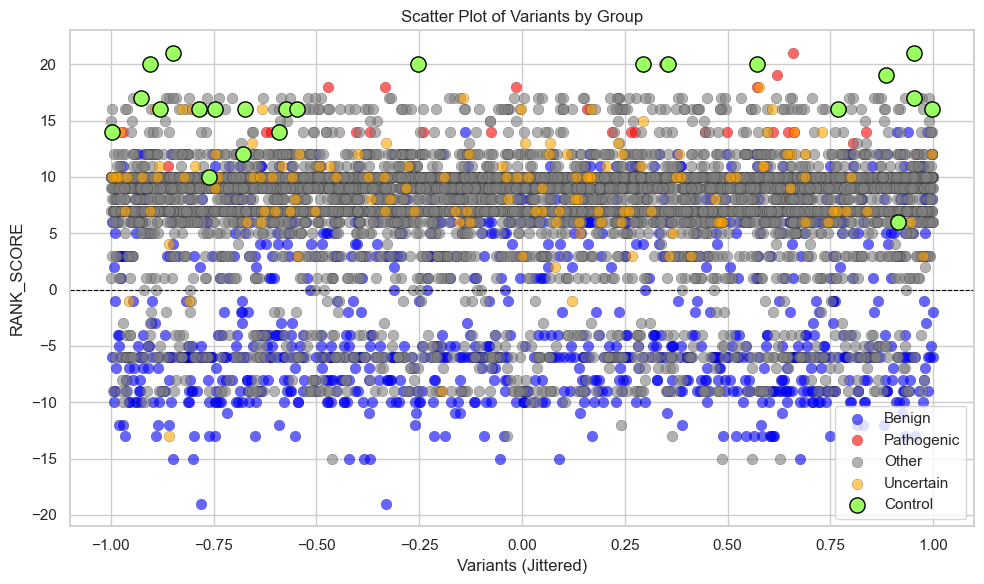

In [997]:
# Scatter Plot Groups
def plot_scatter_with_controls(df, score_col="RANK_SCORE", group_col="GROUP", control_col="IS_CONTROL"):
    """
    Creates a scatter plot with jitter, coloring by group, and highlighting controls.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data.
    - score_col (str): Column for the score to plot on the y-axis.
    - group_col (str): Column for the groups to color points.
    - control_col (str): Column indicating control variants (boolean).
    """
    # Generate jitter for x-axis
    jitter = np.random.uniform(-1.0, 1.0, size=len(df))

    # Assign colors for groups
    group_colors = {
        "benign": "blue",
        "pathogenic": "red",
        "other": "gray",
        "uncertain": "orange",
    }

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    for group, color in group_colors.items():
        subset = df[df[group_col] == group]
        plt.scatter(
            x=jitter[subset.index],
            y=subset[score_col],
            s=60,
            label=group.capitalize(),
            color=color,
            alpha=0.6,
            edgecolor="black" if control_col in subset.columns else None,
            linewidth=0.2,
        )

    # Highlight controls
    controls = df[df[control_col]]
    plt.scatter(
        x=jitter[controls.index],
        y=controls[score_col],
        facecolors="#9AFF60",
        edgecolors="black",
        label="Control",
        s=120,
    )

    # Plot formatting
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.xlabel("Variants (Jittered)")
    plt.ylabel(score_col)
    plt.title("Scatter Plot of Variants by Group")
    plt.legend()
    plt.tight_layout()
    plt.savefig("scatter_by_group_with_controls.png")
    plt.show()

# Call the function
plot_scatter_with_controls(df)

## Reduce Noice and Focus on Benign and Pathogenic Groups
- Retain rows where the GROUP is either Benign or Pathogenic
- Calculate adjusted score (RANK_SCORE - CLIN)
- visualize separatione between Benign and Pathogenic groups by ADJUSTED_SCORE in a violin plot
- visualize ADJUSTED_SCORE distribution in a density plot


### Step 1 & 2: Filter and Adjust Scores
{'Total Rows': 1381, 'Group Counts': {'benign': 1342, 'pathogenic': 39}, 'Adjusted Score Range': (-17.0, 15.0)}


In [999]:
# Step 1: Filter for Benign and Pathogenic groups
filtered_df = df[df['GROUP'].isin(['benign', 'pathogenic'])].copy()

# Step 2: Calculate ADJUSTED_SCORE
#filtered_df['ADJUSTED_SCORE'] = (filtered_df['RANK_SCORE'] - filtered_df['CLIN'])

# Summarize the filtered dataset
filtered_summary = {
    "Total Rows": filtered_df.shape[0],
    "Group Counts": filtered_df['GROUP'].value_counts().to_dict(),
    "Adjusted Score Range": (filtered_df['ADJUSTED_SCORE'].min(), filtered_df['ADJUSTED_SCORE'].max())
}

print(filtered_summary)

{'Total Rows': 1381, 'Group Counts': {'benign': 1342, 'pathogenic': 39}, 'Adjusted Score Range': (-17.0, 15.0)}


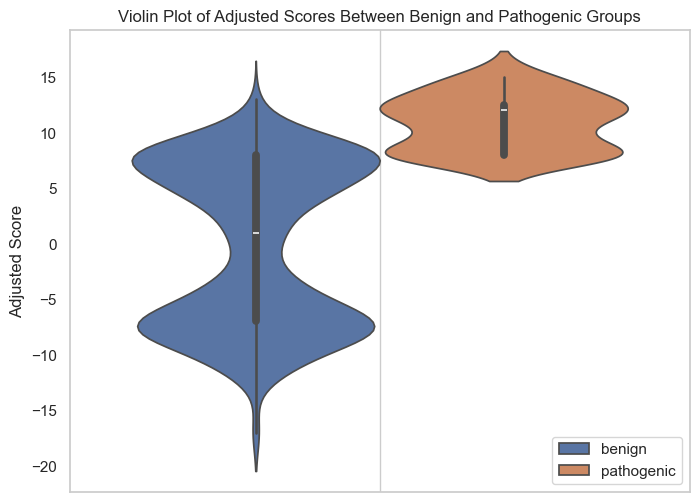

In [901]:
# Violin Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=filtered_df,
    hue='GROUP',
    y='ADJUSTED_SCORE',
    
)
plt.title("Violin Plot of Adjusted Scores Between Benign and Pathogenic Groups")
plt.ylabel("Adjusted Score")
plt.grid()
plt.legend(loc="lower right")
plt.savefig("violin_adjusted_scores_by_group.png")
plt.show()

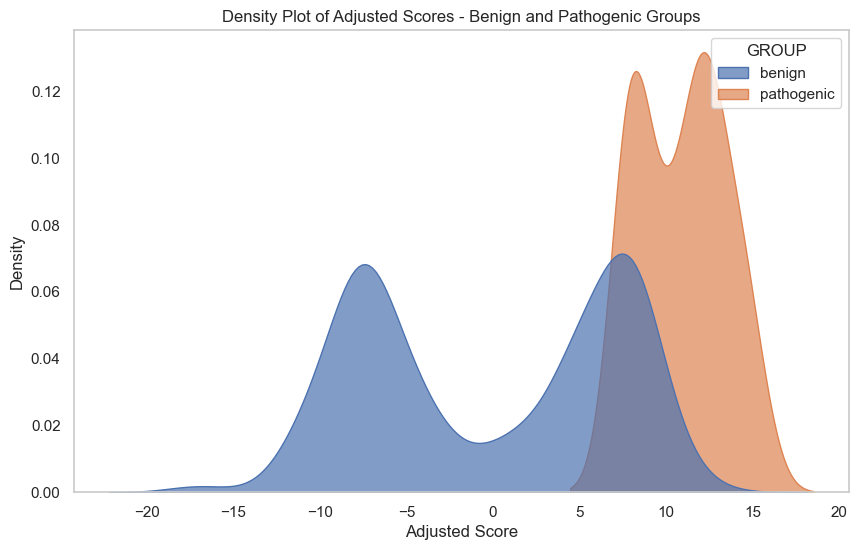

In [902]:
# Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=filtered_df,
    x='ADJUSTED_SCORE',
    hue='GROUP',
    fill=True,
    common_norm=False,
    alpha=0.7
)
plt.title("Density Plot of Adjusted Scores - Benign and Pathogenic Groups")
plt.xlabel("Adjusted Score")
plt.ylabel("Density")
plt.grid()
plt.savefig("density_adjusted_by_group.png")
plt.show()

## Threshold Analysis
- analyze overlaps
- iterate steps for re-weighting

Optimal Threshold (Max F1-Score): 11


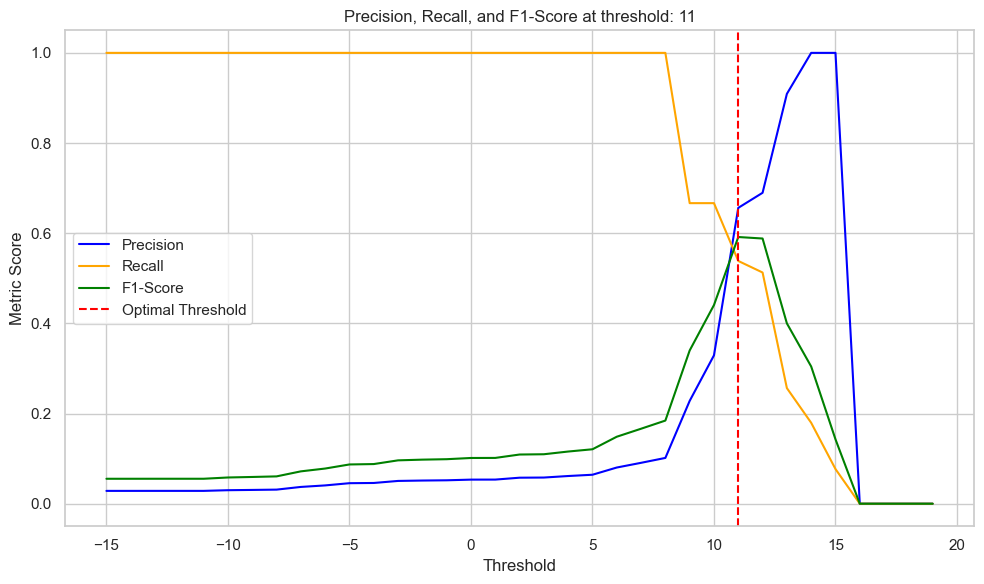

In [974]:
# Workflow 1: Threshold Analysis



# Step 1: Define a function to calculate metrics for thresholds
def calculate_metrics_by_threshold(scores, labels, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (scores >= threshold).astype(float)
        precision = precision_score(labels, y_pred, zero_division=0)
        recall = recall_score(labels, y_pred, zero_division=0)
        f1 = f1_score(labels, y_pred, zero_division=0)
        results.append({"threshold": threshold, "precision": precision, "recall": recall, "f1_score": f1})
    return pd.DataFrame(results)

# Step 2: Define a function to visualize the metrics
def visualize_metrics(metrics_df):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df["threshold"], metrics_df["precision"], label="Precision", color="blue")
    plt.plot(metrics_df["threshold"], metrics_df["recall"], label="Recall", color="orange")
    plt.plot(metrics_df["threshold"], metrics_df["f1_score"], label="F1-Score", color="green")
    plt.axvline(metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"], color="red", linestyle="--", label="Optimal Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    # Find the threshold with the maximum F1-Score
    optimal_threshold = metrics_df.loc[metrics_df["f1_score"].idxmax(), "threshold"]
    plt.title(f"Precision, Recall, and F1-Score at threshold: {optimal_threshold}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"threshold_analysis_threshold: {optimal_threshold}.png")
    # From the plot, select the threshold that maximizes your chosen metric.

    print(f"Optimal Threshold (Max F1-Score): {optimal_threshold}")
    plt.show()

# Step 3: Run the workflow
# Assuming `df` has the columns "ADJUSTED_SCORE" and "GROUP" with 'benign' and 'pathogenic' labels
filtered_df = filtered_df[filtered_df["GROUP"].isin(["benign", "pathogenic"])]
y_true = (filtered_df["GROUP"] == "pathogenic").astype(int)

thresholds = range(-15, 20)
# Calculate metrics
threshold_metrics = calculate_metrics_by_threshold(filtered_df["ADJUSTED_SCORE"], y_true, thresholds)

# Visualize metrics
visualize_metrics(threshold_metrics)



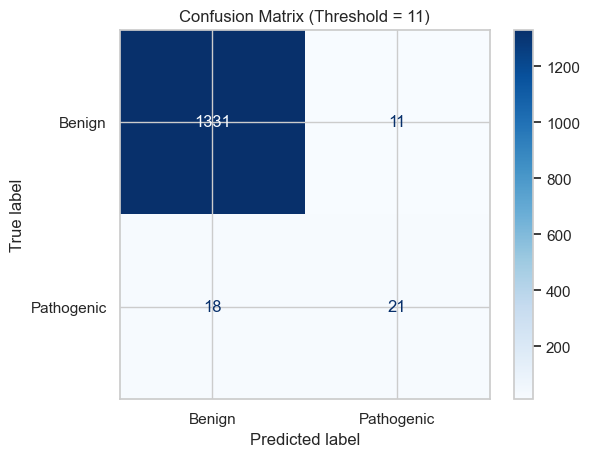

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1342
  Pathogenic       0.66      0.54      0.59        39

    accuracy                           0.98      1381
   macro avg       0.82      0.77      0.79      1381
weighted avg       0.98      0.98      0.98      1381



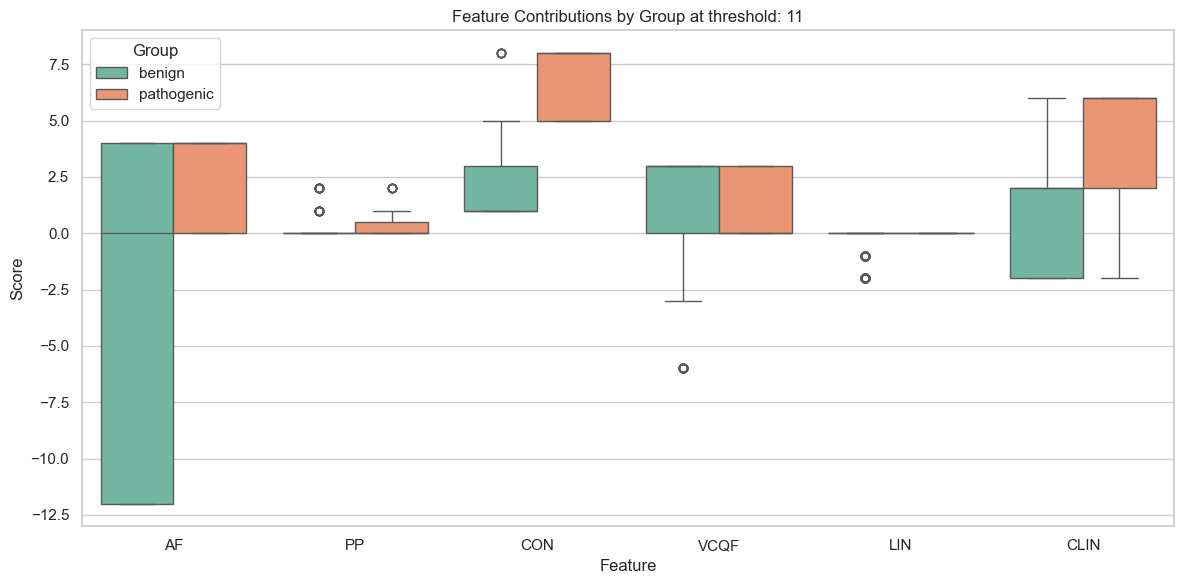

In [975]:
# Workflow 2: Calculate and Visualize Metrics for Optimal Threshold 


# Function to classify variants based on the optimal threshold
def classify_variants(df, threshold):
    df = df.copy()
    df['y_pred'] = (df['ADJUSTED_SCORE'] >= threshold).astype(int)
    df['y_true'] = df['GROUP'].map({'benign': 0, 'pathogenic': 1})
    return df

# Step 1: Define functions to plot the confusion matrix and feature contributions
def plot_confusion_matrix(df, threshold):
    # Classify variants
    df = classify_variants(df, threshold)
    
    # Extract true and predicted labels
    y_true = df['y_true']
    y_pred = df['y_pred']
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Pathogenic"])
    
    # Plot confusion matrix
    disp.plot(cmap='Blues', values_format='d')
    disp.ax_.set_title(f"Confusion Matrix (Threshold = {threshold})")
    
    # Save as PNG
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.savefig(f"confusion_matrix_threshold_{threshold}.png")
    plt.show()
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Pathogenic"]))
    
    return cm

def plot_feature_contributions(melted_df, threshold):
    # Plot feature contributions
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted_df, x="Feature", y="Score", hue="GROUP", palette="Set2")
    plt.title(f"Feature Contributions by Group at threshold: {threshold}")
    plt.xlabel("Feature")
    plt.ylabel("Score")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.savefig(f"feature_contributions_at_threshold_{threshold}.png")
    plt.show()

# Step 2: Apply the optimal threshold
optimal_threshold = threshold_metrics.loc[threshold_metrics["f1_score"].idxmax(), "threshold"]
y_pred = (filtered_df["ADJUSTED_SCORE"] >= optimal_threshold).astype(int)

# Step 3: Plot the confusion matrix
plot_confusion_matrix(filtered_data, optimal_threshold)

# Melt the data for plotting feature contributions
melted_data = filtered_df.melt(
    id_vars=["GROUP"], 
    value_vars=["AF", "PP", "CON", "VCQF", "LIN", "CLIN"], 
    var_name="Feature", 
    value_name="Score"
)
plot_feature_contributions(melted_data, optimal_threshold)

Optimal Threshold (Max F1-Score): 12


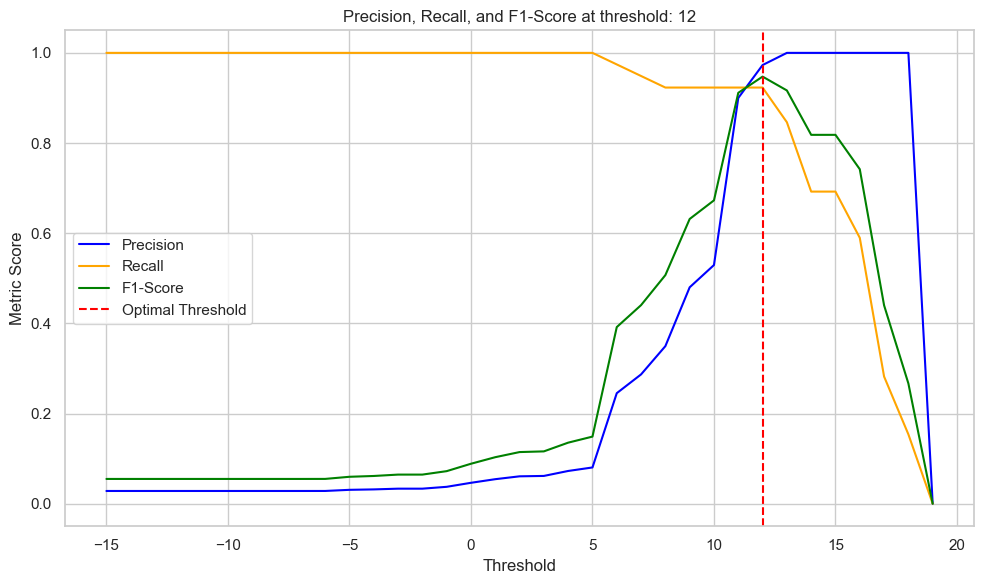

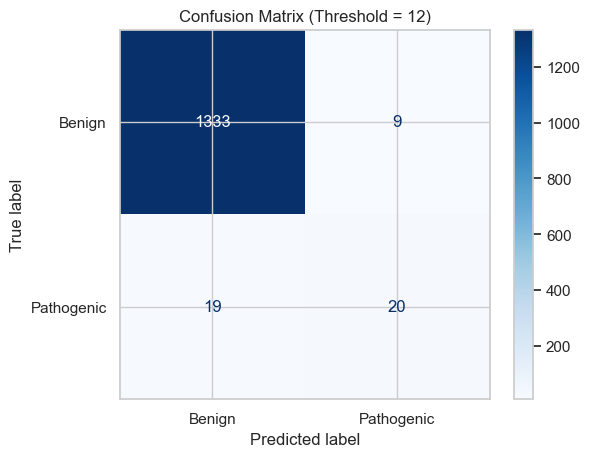

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      1342
  Pathogenic       0.69      0.51      0.59        39

    accuracy                           0.98      1381
   macro avg       0.84      0.75      0.79      1381
weighted avg       0.98      0.98      0.98      1381



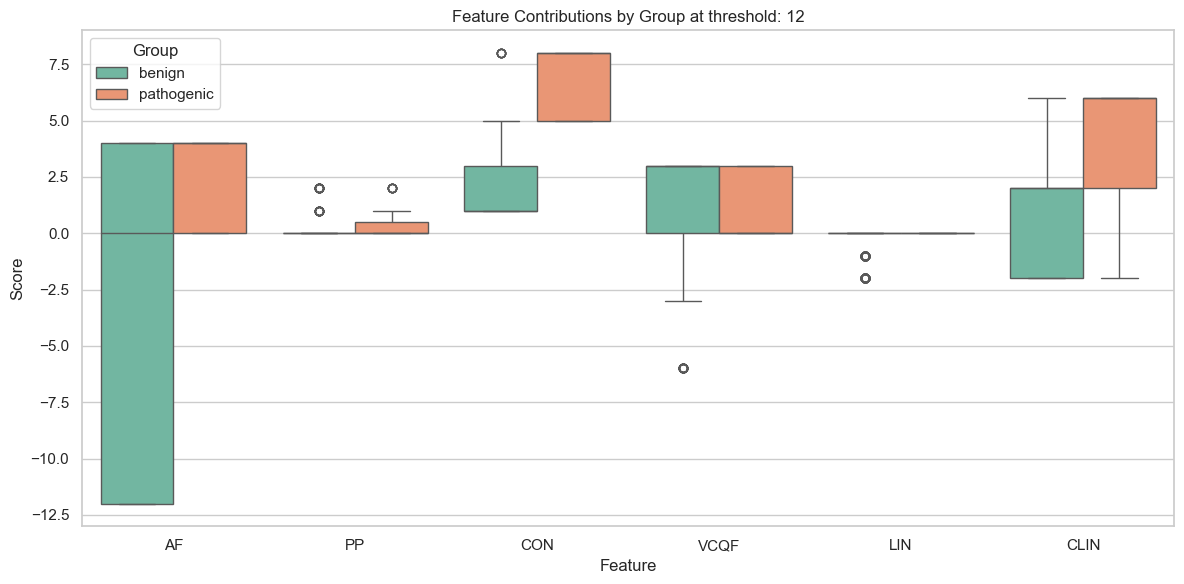

In [993]:
# Workflow 3: Reweight, Recalculate, and Revisualize 

# Step 1: Define new weights
NEW_WEIGHTS = {
    "AF": 0.4,
    "PP": 1.1,
    "CON": 1.2,
    "VCQF": 0.1,
    "LIN": 0.1,
    "CLIN": 1.2
}

# Step 2: Recalculate rank scores
def recalculate_rank_scores(df, weights):
    df["UPDATED_RANK_SCORE"] = (
        df["AF"] * weights["AF"] +
        df["PP"] * weights["PP"] +
        df["CON"] * weights["CON"] +
        df["VCQF"] * weights["VCQF"] +
        df["LIN"] * weights["LIN"] +
        df["CLIN"] * weights["CLIN"]
    )
    return df

df = recalculate_rank_scores(filtered_df, NEW_WEIGHTS)

melted_data = df.melt(
    id_vars=["GROUP"], 
    value_vars=["AF", "PP", "CON", "VCQF", "LIN", "CLIN"], 
    var_name="Feature", 
    value_name="Score"
)

# Step 3: Repeat Threshold Analysis
threshold_metrics_updated = calculate_metrics_by_threshold(df["UPDATED_RANK_SCORE"], y_true, thresholds)
visualize_metrics(threshold_metrics_updated)

# Step 4: Plot Confusion Matrix for Updated Scores
optimal_threshold_updated = threshold_metrics_updated.loc[threshold_metrics_updated["f1_score"].idxmax(), "threshold"]
y_pred_updated = (df["UPDATED_RANK_SCORE"] >= optimal_threshold_updated).astype(int)
plot_confusion_matrix(df, optimal_threshold_updated)
plot_feature_contributions(melted_data, optimal_threshold_updated)

In [ ]:
## Proposed Refinement Steps

### Analyze Feature Contributions
	•	Decompose the RANK_SCORE into its contributing categories (AF, PP, CON, VCQF, LIN, CLIN) for the benign and pathogenic groups.
	•	Visualize the contributions for each group to identify potential feature-level discrepancies. For example:
	•	Boxplots or violin plots for each feature by group.
	•	Heatmaps to show feature interactions.
	•	Goal: Pinpoint features that disproportionately contribute to misclassifications.

### Reweight Feature Contributions
	•	Adjust the weights of the contributing categories in RANK_SCORE based on the analysis:
	•	Reduce weights for features contributing noise (e.g., overly high scores for benign variants in the pathogenic range).
	•	Increase weights for features highly discriminative of pathogenic variants (e.g., CLIN).
	•	Recalculate RANK_SCORE and visualize adjusted contributions.

### Test New Thresholds
	•	Perform a threshold analysis on the recalibrated RANK_SCORE:
	•	Generate precision, recall, and F1-score curves.
	•	Identify the new optimal threshold.
	•	Compare the confusion matrix with the previous one to evaluate improvement.

### Incorporate Feature Quality Checks
	•	Examine the quality of individual features (e.g., missing or erroneous annotations in SIFT, PolyPhen, or gnomAD_AF).
	•	Filter out low-quality annotations or rows with missing data in critical features.
	•	Recompute RANK_SCORE and reanalyze.

### Validate the Model
	•	Split the annotated dataset into a training set (e.g., 70%) and testing set (e.g., 30%).
	•	Train the model on the training set to optimize feature weights.
	•	Evaluate the model on the testing set using metrics such as AUC, precision, recall, and F1-score.

### Visualize Results
	•	For each refinement iteration:
	•	Plot feature contributions for both groups.
	•	Update confusion matrix, precision-recall curves, and ROC curve.
	•	Overlay before-and-after visualizations to demonstrate improvements.

## Adjusting Feature Weights 
The goal of this step is to reweight the contributions of the scoring model’s features to improve the separation between benign and pathogenic variants.

### Analyze Current Contributions:
Based on the boxplot, we know that AF, CON, and CLIN are the dominant features.
Features like VCQF, PP, and LIN show less impact and could either be down-weighted or excluded.

### Define New Weights:
	•	Assign higher weights to AF, CON, and CLIN.
	•	Reduce or set the weight of LIN to zero.
	•	Adjust weights for PP and VCQF based on their overlaps and low discriminative power.

### Recalculate Adjusted Scores:
	•	Update the adjusted score formula as follows:

\text{Adjusted Score} = w_{\text{AF}} \cdot \text{AF} + w_{\text{PP}} \cdot \text{PP} + w_{\text{CON}} \cdot \text{CON} + w_{\text{VCQF}} \cdot \text{VCQF} + w_{\text{LIN}} \cdot \text{LIN} + w_{\text{CLIN}} \cdot \text{CLIN}

	•	Implement the weights as a dictionary for flexibility.
### Reevaluate Metrics:
	•	Visualize the updated feature contributions.
	•	Rerun threshold analysis to find the optimal threshold.
	•	Evaluate the confusion matrix to quantify the improvement.

## Prepare Data for Metrics Calculation
### Binary metrics (pathogenic vs benign)
1. Exclude rows classified as other or uncertain

2. Binary Labels (y_true)
   Use the GROUP column to label variants as 1 (pathogenic) or 0 (benign

3. Predictions (y_pred):
   Use a decision threshold on NO_CLIN_RANK_SCORE to classify variants.

4. Scores (y_scores):
   Use NO_CLIN_RANK_SCORE directly to calculate AUC and for continuous score evaluation.

In [133]:
# 1. Fine-Tune Feature Weights
def fine_tune_weights(df):
    """
    Apply fine-tuned weights to the scoring formula for further improvement.
    """
    fine_tuned_weights = {"AF": 2.0, "PP": 1.5, "CON": 0.8, "VCQF": 1.2, "LIN": 1.0, "CLIN": 0.6}
    df["FINE_TUNED_RANK_SCORE"] = (
        df["AF"] * fine_tuned_weights["AF"] +
        df["PP"] * fine_tuned_weights["PP"] +
        df["CON"] * fine_tuned_weights["CON"] +
        df["VCQF"] * fine_tuned_weights["VCQF"] +
        df["LIN"] * fine_tuned_weights["LIN"] +
        df["CLIN"] * fine_tuned_weights["CLIN"]
    )
    print("Applied fine-tuned weights and recalculated FINE_TUNED_RANK_SCORE.")
    return df

# 2. Evaluate Performance Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def calculate_performance_metrics(df, score_column="FINE_TUNED_RANK_SCORE", threshold=10):
    """
    Calculate precision, recall, F1-score, and AUC for the scoring model.
    """
    y_true = df["y_true"]
    y_pred = df[score_column].apply(lambda x: 1 if x >= threshold else 0)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, df[score_column])

    print(f"Performance Metrics (Threshold = {threshold}):")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}")

    return precision, recall, f1, auc

# 3. Remove LIN Feature if Needed
def remove_lin_feature(df):
    """
    Remove LIN column if it consistently contributes zero to the scoring model.
    """
    if df["LIN"].sum() == 0:
        df.drop(columns=["LIN"], inplace=True)
        print("LIN feature removed from the dataset.")
    else:
        print("LIN feature retained in the dataset.")
    return df

# 4. Visualize Fine-Tuned Scores Across Entire Dataset
def visualize_fine_tuned_scores(df):
    """
    Plot the distribution of FINE_TUNED_RANK_SCORE across the entire dataset.
    """
    sns.histplot(df["FINE_TUNED_RANK_SCORE"], bins=30, kde=True, color="blue")
    plt.title("Distribution of FINE_TUNED_RANK_SCORE Across Dataset")
    plt.xlabel("FINE_TUNED_RANK_SCORE")
    plt.ylabel("Count")
    plt.savefig("reweighted.png")
    plt.show()

# 5. Apply All Steps
def main_further_refinements(df):
    # Step 1: Fine-tune weights
    df = fine_tune_weights(df)

    # Step 2: Evaluate performance metrics
    calculate_performance_metrics(df)

    # Step 3: Remove LIN feature if it contributes nothing
    df = remove_lin_feature(df)

    # Step 4: Visualize fine-tuned scores
    visualize_fine_tuned_scores(df)

    return df

# Uncomment and run when `df` and `y_true` exist
# df = main_further_refinements(df)

/var/folders/nk/k4967rl54mgf_hvvhsr0w9cr0000gn/T/ipykernel_11485/3651460854.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', color='red')  # Diagonal line


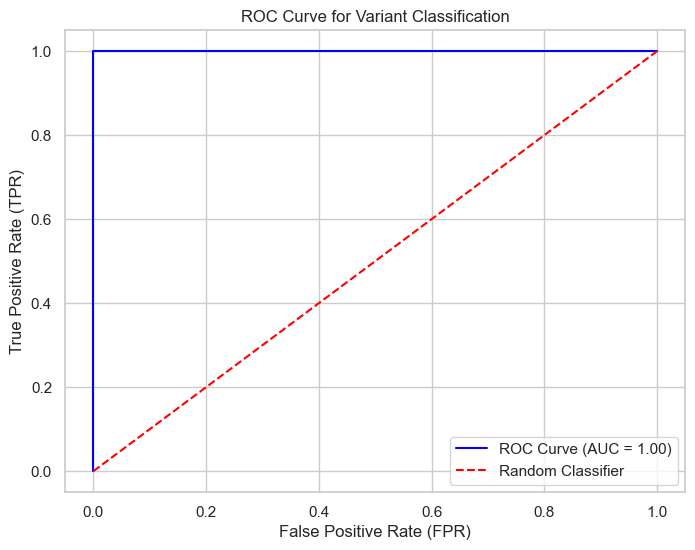

In [1000]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Simulated data: Scores and labels for benign (0) and pathogenic (1) variants
# Replace with real data as appropriate.
np.random.seed(42)  # For reproducibility
benign_scores = np.random.normal(loc=-1, scale=1, size=100)  # Example scores for benign variants
pathogenic_scores = np.random.normal(loc=3, scale=1, size=100)  # Example scores for pathogenic variants

# Combine scores and create labels
scores = np.concatenate([benign_scores, pathogenic_scores])
labels = np.array([0] * len(benign_scores) + [1] * len(pathogenic_scores))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc_score = roc_auc_score(labels, scores)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', color='red')  # Diagonal line
plt.title('ROC Curve for Variant Classification')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("roc.png")
plt.show()

Applied fine-tuned weights and recalculated FINE_TUNED_RANK_SCORE.
Performance Metrics (Threshold = 10):
Precision: 0.00
Recall: 0.93
F1-Score: 0.01
AUC: 0.70
LIN feature retained in the dataset.


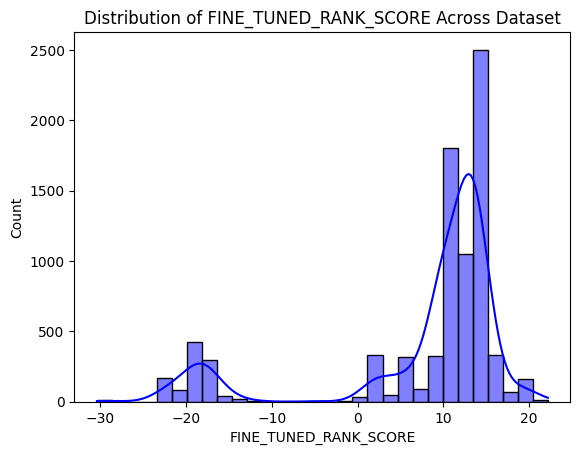

In [134]:
df = main_further_refinements(df)

In [66]:
# Prepare Data for Metrics Calculation

# extract the relevant columns (RANK_SCORE or NO_CLIN_RANK_SCORE, and the GROUP column for ground truth)

df["y_true"] = df["GROUP"].apply(lambda x: 1 if x == "pathogenic" else 0)  # Convert GROUP to binary labels
threshold = 10.0  # Example threshold for classification

# Predicted labels based on the threshold
df["y_pred"] = df["NO_CLIN_RANK_SCORE"].apply(lambda x: 1 if x >= threshold else 0)

# Scores to use for AUC calculation
y_true = df["y_true"].values  # Ground truth labels
y_pred = df["y_pred"].values  # Predicted binary labels
y_scores = df["NO_CLIN_RANK_SCORE"].values  # Continuous scores

In [67]:
df = main_further_refinements(df)

NameError: name 'main_further_refinements' is not defined

In [137]:
# 1. Improve Precision by Testing Higher Thresholds
def evaluate_at_threshold(df, score_column="FINE_TUNED_RANK_SCORE", thresholds=[10, 12, 15]):
    """
    Evaluate performance metrics at different thresholds.
    """
    results = []
    for t in thresholds:
        precision, recall, f1, auc = calculate_performance_metrics(df, score_column=score_column, threshold=t)
        results.append({"Threshold": t, "Precision": precision, "Recall": recall, "F1-Score": f1, "AUC": auc})
    return pd.DataFrame(results)

# 2. Rebalance Feature Weights
def apply_refined_weights(df):
    """
    Apply refined weights to further optimize the scoring system.
    """
    refined_weights = {"AF": 1.5, "PP": 1.2, "CON": 1.0, "VCQF": 1.0, "LIN": 0.5, "CLIN": 1.0}
    df["REFINED_RANK_SCORE"] = (
        df["AF"] * refined_weights["AF"] +
        df["PP"] * refined_weights["PP"] +
        df["CON"] * refined_weights["CON"] +
        df["VCQF"] * refined_weights["VCQF"] +
        df["LIN"] * refined_weights["LIN"] +
        df["CLIN"] * refined_weights["CLIN"]
    )
    print("Applied refined weights and recalculated REFINED_RANK_SCORE.")
    return df

# 3. Plot Metrics Across Thresholds
def plot_metrics_across_thresholds(df, score_column="REFINED_RANK_SCORE", threshold_range=(-30, 30, 2)):
    """
    Plot precision, recall, and F1-score across a range of thresholds.
    """
    thresholds = range(*threshold_range)
    precision_list, recall_list, f1_list = [], [], []

    for t in thresholds:
        precision, recall, f1, _ = calculate_performance_metrics(df, score_column=score_column, threshold=t)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_list, label="Precision", marker="o")
    plt.plot(thresholds, recall_list, label="Recall", marker="x")
    plt.plot(thresholds, f1_list, label="F1-Score", marker="s")
    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title("Performance Metrics Across Thresholds")
    plt.legend()
    plt.grid(True)
    plt.savefig("performance_metrics.png")
    plt.show()

# 4. Remove LIN Feature if It Remains Underutilized
def check_and_remove_lin(df):
    """
    Check the contribution of LIN and remove it if necessary.
    """
    if df["LIN"].sum() == 0:
        df.drop(columns=["LIN"], inplace=True)
        print("LIN feature removed from the dataset.")
    else:
        print("LIN feature retained in the dataset.")
    return df

# Example Usage
def main_refined_implementation(df):
    # Step 1: Evaluate performance at higher thresholds
    thresholds_to_test = [10, 12, 15]
    threshold_results = evaluate_at_threshold(df, thresholds=thresholds_to_test)
    print("Performance Metrics at Different Thresholds:")
    print(threshold_results)

    # Step 2: Apply refined weights
    df = apply_refined_weights(df)

    # Step 3: Plot metrics across a range of thresholds
    plot_metrics_across_thresholds(df)

    # Step 4: Check and remove LIN feature if needed
    df = check_and_remove_lin(df)

    return df

# Uncomment and run when `df` is defined
# df = main_refined_implementation(df)

In [68]:
# 1. Set the Optimal Threshold and Calculate Metrics
def calculate_optimal_threshold_metrics(df, score_column="REFINED_RANK_SCORE", optimal_threshold=20):
    """
    Calculate precision, recall, F1-score, and AUC at the optimal threshold.
    """
    precision, recall, f1, auc = calculate_performance_metrics(
        df, score_column=score_column, threshold=optimal_threshold
    )
    print(f"Optimal Threshold Metrics (Threshold = {optimal_threshold}):")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, AUC: {auc:.2f}")
    return precision, recall, f1, auc

# 2. Analyze False Positives and Negatives
def analyze_misclassifications(df, score_column="REFINED_RANK_SCORE", optimal_threshold=20):
    """
    Identify false positives and false negatives at the optimal threshold.
    """
    df["y_pred"] = df[score_column].apply(lambda x: 1 if x >= optimal_threshold else 0)
    
    false_positives = df[(df["y_pred"] == 1) & (df["y_true"] == 0)]
    false_negatives = df[(df["y_pred"] == 0) & (df["y_true"] == 1)]

    print(f"Number of False Positives: {len(false_positives)}")
    print(f"Number of False Negatives: {len(false_negatives)}")
    
    return false_positives, false_negatives

# 3. Refine Feature Weights Based on Misclassifications
def refine_weights_based_on_misclassifications(df, false_positives, false_negatives):
    """
    Analyze the feature contributions in false positives and false negatives to guide reweighting.
    """
    print("\nFeature Contributions in False Positives:")
    print(false_positives[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

    print("\nFeature Contributions in False Negatives:")
    print(false_negatives[["AF", "PP", "CON", "VCQF", "LIN", "CLIN"]].describe())

    # Recommendations for reweighting can be derived from these summaries

# Example Usage
def main_optimal_threshold_analysis(df):
    # Step 1: Calculate metrics at the optimal threshold
    optimal_threshold = 20
    precision, recall, f1, auc = calculate_optimal_threshold_metrics(df, optimal_threshold=optimal_threshold)

    # Step 2: Analyze false positives and false negatives
    false_positives, false_negatives = analyze_misclassifications(df, optimal_threshold=optimal_threshold)

    # Step 3: Refine weights based on misclassifications
    refine_weights_based_on_misclassifications(df, false_positives, false_negatives)

    return df, false_positives, false_negatives

# Uncomment and run when `df` and `y_true` exist
# df, false_positives, false_negatives = main_optimal_threshold_analysis(df)

In [340]:
df, false_positives, false_negatives = main_optimal_threshold_analysis(df)

Performance Metrics (Threshold = 20):
Precision: 0.53
Recall: 0.30
F1-Score: 0.38
AUC: 0.92
Optimal Threshold Metrics (Threshold = 20):
Precision: 0.53, Recall: 0.30, F1-Score: 0.38, AUC: 0.92
Number of False Positives: 7
Number of False Negatives: 19

Feature Contributions in False Positives:
        AF        PP  CON  VCQF  LIN  CLIN
count  7.0  7.000000  7.0   7.0  7.0   7.0
mean   4.0  1.571429  5.0   3.0  0.0   6.0
std    0.0  0.786796  0.0   0.0  0.0   0.0
min    4.0  0.000000  5.0   3.0  0.0   6.0
25%    4.0  1.500000  5.0   3.0  0.0   6.0
50%    4.0  2.000000  5.0   3.0  0.0   6.0
75%    4.0  2.000000  5.0   3.0  0.0   6.0
max    4.0  2.000000  5.0   3.0  0.0   6.0

Feature Contributions in False Negatives:
              AF         PP        CON       VCQF   LIN       CLIN
count  19.000000  19.000000  19.000000  19.000000  19.0  19.000000
mean    1.263158   0.157895   7.368421   0.789474   0.0   3.789474
std     1.910268   0.501460   1.256562   1.357242   0.0   2.485043
min    

## Visualize Individual Feature Distributions

This function creates boxplots for each feature (AF, PP, etc.) comparing controls (is_control=True) to non-controls (is_control=False).
	•	Output:
	•	Boxplots for each feature, showing how they vary between controls and non-controls.

In [69]:
scatter_plot_all_by_group(df, "VARIANT", "RANK_SCORE")

KeyError: 'Color'

<Figure size 1200x600 with 0 Axes>

In [70]:
scatter_plot_with_controls(df, "VARIANT", "RANK_SCORE")

TypeError: scatter_plot_with_controls() takes 1 positional argument but 3 were given

In [71]:
stacked_barplot_for_controls(df)

KeyError: 'is_control'

#### Describe the extracted dataset and the filtered dataset
The dataset contains 8145 variants: 
- All variants have RankScore
- 1555 variants have CLNSIG annotation from ClinVar
- etc.

### Aims - evaluation
- Visualize rankscore distribution
- - Visualize separation between hypothesized groups "Benign", "Pathogenic"
- Analyze how known variants are scored

**Analyze positive controls (HD829)**
- Visualize the positive controls from the VCF
  - What are their RankScores?
  - How are they scored in the different Categories? 

df